## <code>LPGerchbergSaxton_SLM.ipynb </code> 
    - 01-12-2022, Keller-C10
    - Raghav K. Chhetri
    - Phase Retrievel via Gerchberg-Saxton algorithm to generate holograms for an SLM using LightPipes for Python
 
    Reference MATLAB scripts: 
    - Original code by Dr F.A. van Goor, University of Twente (April 2010)
    - Reorganized by Adam Packer (December 2013) -> SLMPhaesMaskMaker_LightPipes.m

In [1]:
from LightPipes import *
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from os.path import join
import time
import sys

In [2]:
print('Environment: {}'.format(sys.exec_prefix))
print('Executable: {}'.format(sys.executable))
print('Python version: {}'.format(sys.version))
print('Numpy', np.__version__)
print('Matplotlib', matplotlib.__version__)
print('LightPipes', LPversion)
LPtest()

Environment: C:\Users\SiMView\anaconda3\envs\matrix
Executable: C:\Users\SiMView\anaconda3\envs\matrix\python.exe
Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy 1.21.2
Matplotlib 3.5.0
LightPipes 2.1.2
LightPipes for Python: test passed.
LightPipes version: 2.1.2


#### Constant Optical System Parameters

In [3]:
#Spatial offset of beams in sample plane
dx  = 75*um 
dz = 70*um 

#Separation along X between beams on the same focal plane 
sepx  = 4*dz

#Magnification from sample to Apodizing Mask
MagAM = 6 

#Spacing at the Apodizing Mask
dX = MagAM*dx 
dZ = MagAM*dz 
sepX = MagAM*sepx 

fSLM = 750*mm
SLMpixel = 9.2*um
SLMheight = 1920
SLMwidth = 1152

In [4]:
# To shift the beams (-ve values here moves the beam up i.e., along +Z in the microscope)
move_beam1 = 0*um*MagAM
move_beam4 = 0*um*MagAM
move_beam7 = 0*um*MagAM

move_beam2 = 0*um*MagAM
move_beam5 = 0*um*MagAM
move_beam8 = 0*um*MagAM

move_beam3 = 0*um*MagAM
move_beam6 = 0*um*MagAM
move_beam9 = 0*um*MagAM
# 20*dZ/70

### <code>generate_masks</code>

In [6]:
def generate_masks(wavelength = 488*nm, Niter = 12, tag = 'MATRIX'):

    #Grid for the computation of the optical fields
    gridsize = np.ceil((fSLM*wavelength/SLMpixel)/dZ)*dZ

    #Optic axis co-ordinate(zero-order beam)
    Oaxis = gridsize/2

    #Define the position of the center beam in the 3x3 array
    X = Oaxis
    Z = Oaxis - 2*dZ

    #Choose Nunits 'Number of grid-units per dZ' such that gridpixels > SLMheight
    Nunits = 70; #even; For 488, 30 and up; For 561/631, 20 and up; [20,30,60,70,140,210]
    unit = dZ/Nunits
    gridpixels = int(gridsize/unit)

    print('Pixels in the grid:', gridpixels)
    print('Pixels along SLM height:',SLMheight)
    print('SLM oversampled. OK to proceed') if gridpixels > SLMheight else print('SLM undersampled. Increase "Nunits" such that "gridpixels" > "SLMheight"')

#Input field on the SLM    
    beamD = 1.2*9*mm #1/e diameter on the SLM = 1.2 x FWHM_width
    Field= Begin(gridsize, wavelength, gridpixels) #Plane wave distribution with amplitude 1 and phase 0
    Field= GaussBeam(Field, beamD/2)

    SLMfield = RectAperture(Field, sx=SLMheight*SLMpixel, sy=SLMwidth*SLMpixel, x_shift=0.0, y_shift=0.0, angle=0.0)
    print(type(SLMfield.field), SLMfield.field.dtype, SLMfield.field.shape)

#Define beam-spot positions in the target grid
    if tag == 'MATRIX': # 3 x 3 Beams
        spots_X = np.array([(X-dX)-sepX, X-sepX, (X+dX)-sepX,
                            (X-dX), X, (X+dX),
                            (X-dX)+sepX, X+sepX, (X+dX)+sepX])/unit
        spots_Z = np.array([Z-dZ-move_beam1, Z-move_beam2, Z+dZ-move_beam3,
                            Z-dZ-move_beam4, Z-move_beam5, Z+dZ-move_beam6,
                            Z-dZ-move_beam7, Z-move_beam8, Z+dZ-move_beam9])/unit

    elif tag == 'NEAR': #Beams-3-6-9
        spots_X = np.array([(X+dX)-sepX, (X+dX), (X+dX)+sepX])/unit
        spots_Z = np.array([Z+dZ-move_beam3, Z+dZ-move_beam6, Z+dZ-move_beam9])/unit

    elif tag == 'NEAR_beam3':
        spots_X = np.array([(X+dX)-sepX])/unit
        spots_Z = np.array([Z+dZ-move_beam3])/unit

    elif tag == 'NEAR_beam6':
        spots_X = np.array([X+dX])/unit
        spots_Z = np.array([Z+dZ-move_beam6])/unit

    elif tag == 'NEAR_beam9':
        spots_X = np.array([(X+dX)+sepX])/unit
        spots_Z = np.array([Z+dZ-move_beam9])/unit

    elif tag == 'MID': #Beams-2-5-8
        spots_X = np.array([X-sepX, X, X+sepX])/unit
        spots_Z = np.array([Z-move_beam2, Z-move_beam5, Z-move_beam8])/unit

    elif tag == 'MID_beam2':
        spots_X = np.array([X-sepX])/unit
        spots_Z = np.array([Z-move_beam2])/unit

    elif tag == 'MID_beam5':
        spots_X = np.array([X])/unit
        spots_Z = np.array([Z-move_beam5])/unit

    elif tag == 'MID_beam8':
        spots_X = np.array([X+sepX])/unit
        spots_Z = np.array([Z-move_beam8])/unit

    elif tag == 'FAR': #Beams-1-4-7
        spots_X = np.array([(X-dX)-sepX, (X-dX), (X-dX)+sepX])/unit
        spots_Z = np.array([Z-dZ-move_beam1, Z-dZ-move_beam4, Z-dZ-move_beam7])/unit

    elif tag == 'FAR_beam1':
        spots_X = np.array([(X-dX)-sepX])/unit
        spots_Z = np.array([Z-dZ-move_beam1])/unit

    elif tag == 'FAR_beam4':
        spots_X = np.array([X-dX])/unit
        spots_Z = np.array([Z-dZ-move_beam4])/unit

    elif tag == 'FAR_beam7':
        spots_X = np.array([(X-dX)+sepX])/unit
        spots_Z = np.array([Z-dZ-move_beam7])/unit

    elif tag == 'DIAGONAL': #Beams-1-5-9
        spots_X = np.array([(X-dX)-sepX, X, (X+dX)+sepX])/unit
        spots_Z = np.array([Z-dZ-move_beam1, Z-move_beam5, Z+dZ-move_beam9])/unit

    spots_X = spots_X.astype(int)
    spots_Z = spots_Z.astype(int)
    
#Target pattern
    target = np.zeros((gridpixels, gridpixels)) #Note: LightPipes command 'SubIntensity' needs floats
    for j in range(len(spots_X)):
        target[spots_X[j],spots_Z[j]] = 255
    print(type(target), target.shape, np.min(target), np.max(target), target.dtype)
    
#Plot field intensities
    ISLM = Intensity(SLMfield)
    high= 1000
    hoff= 100
    wide= 600
    woff= 300
    top= len(target)//2 - high//2 + hoff
    bottom= len(target)//2 + high//2 - hoff
    left= len(target)//2 - wide//2 
    right= len(target)//2 + wide//2 - woff

    plt.figure(figsize=(17,17))
    plt.subplot(1,2,1)
    plt.title('Intensity (at SLM)')
    plt.imshow(ISLM,cmap='jet')
    plt.subplot(1,2,2)
    plt.title('Intensity (at target)')
    plt.imshow(target[top:bottom,left:right], cmap='gray')
    plt.show()

#Iteration loop to get phase distribution
    Field = SLMfield
    UniformIntensity = np.ones((gridpixels, gridpixels)) #Matrix filled with 1's to substitute a uniform intensity profile

    t0 = time.time()
    for i in range(Niter):     
    #2-D Fourier transform of the field; Forward transform with index 1
        Field = PipFFT(Field, index = 1)     
    #Substitute the original intensity distribution while leaving the phase unchanged
        Field = SubIntensity(Field, target)
    #Inverse Fourier transform; Back transform with index -1
        Field = PipFFT(Field, index = -1) 
    #Substitute a uniform intensity while leaving the phase unchanged
        Field = SubIntensity(Field, UniformIntensity)
    print('Took', round(time.time()-t0,2), 'sec')

#Extract phase distribution from the field
    Phaze = Phase(Field) 
    PhaseZeroed = Phaze + np.abs(np.min(Phaze))

    # Convert to 8-bit
    Phase8 = PhaseZeroed*(255/np.max(PhaseZeroed))
    print(type(Phase8), Phase8.shape, Phase8.dtype)
    phaseMask8 = Phase8[0:SLMwidth,0:SLMheight].astype('uint8')
    print(type(phaseMask8), phaseMask8.shape, phaseMask8.dtype)

    fig = plt.figure(figsize=(10,6))
    io.imshow(phaseMask8); io.show()

#Save pattern
    outPath= 'C:/Users/SiMView/Documents/'
    outfilename= str(int(wavelength/nm))+ \
    'nm_Target.'+str(Nunits)+ \
    'units.in.'+str(int(dZ/um))+ \
    'um_Niter'+str(Niter)+'_' +tag +'.bmp' 
    io.imsave(join(outPath, outfilename), phaseMask8) 

Pixels in the grid: 8610
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (8610, 8610)
<class 'numpy.ndarray'> (8610, 8610) 0.0 255.0 float64


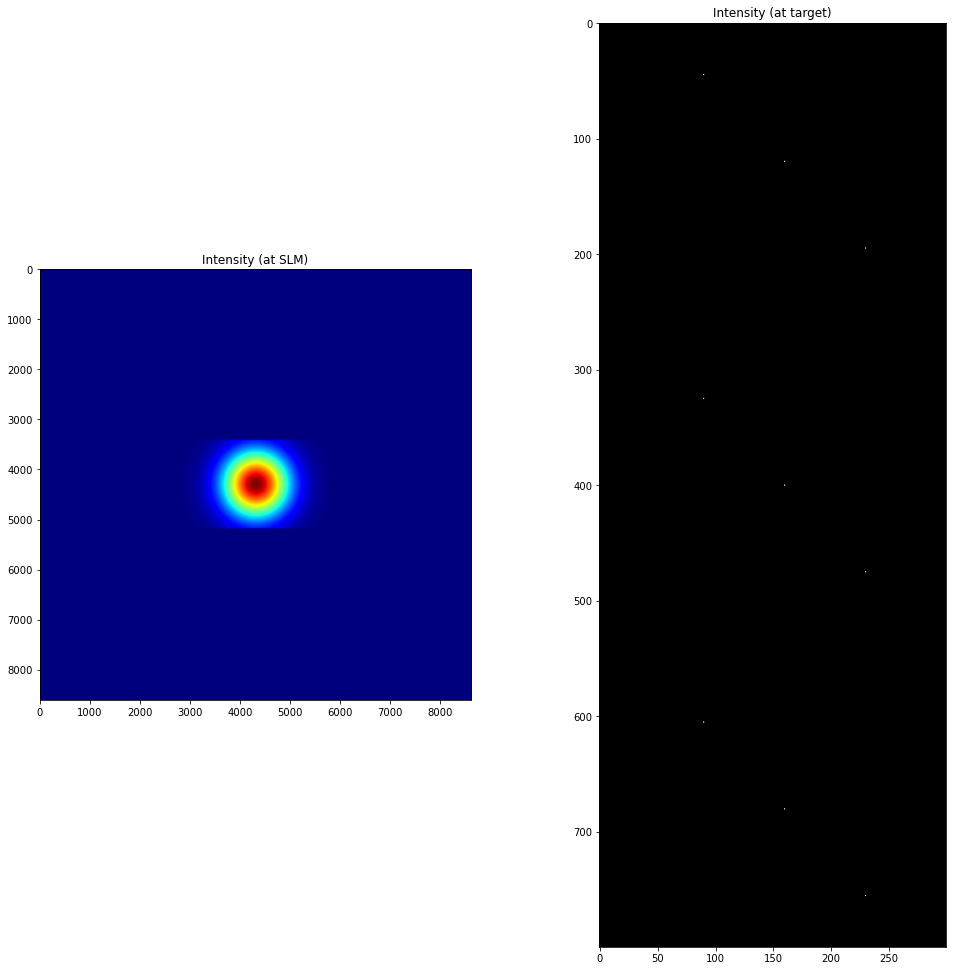

Took 4089.22 sec
<class 'numpy.ndarray'> (8610, 8610) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


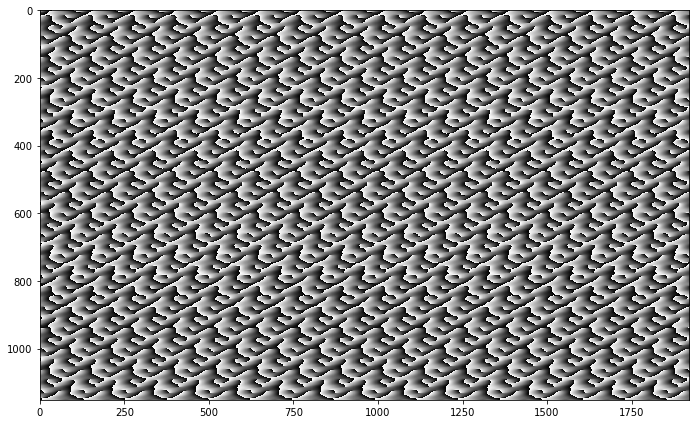

In [11]:
generate_masks(631*nm, Niter = 100, tag = 'MATRIX')

Pixels in the grid: 8610
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (8610, 8610)
<class 'numpy.ndarray'> (8610, 8610) 0.0 255.0 float64


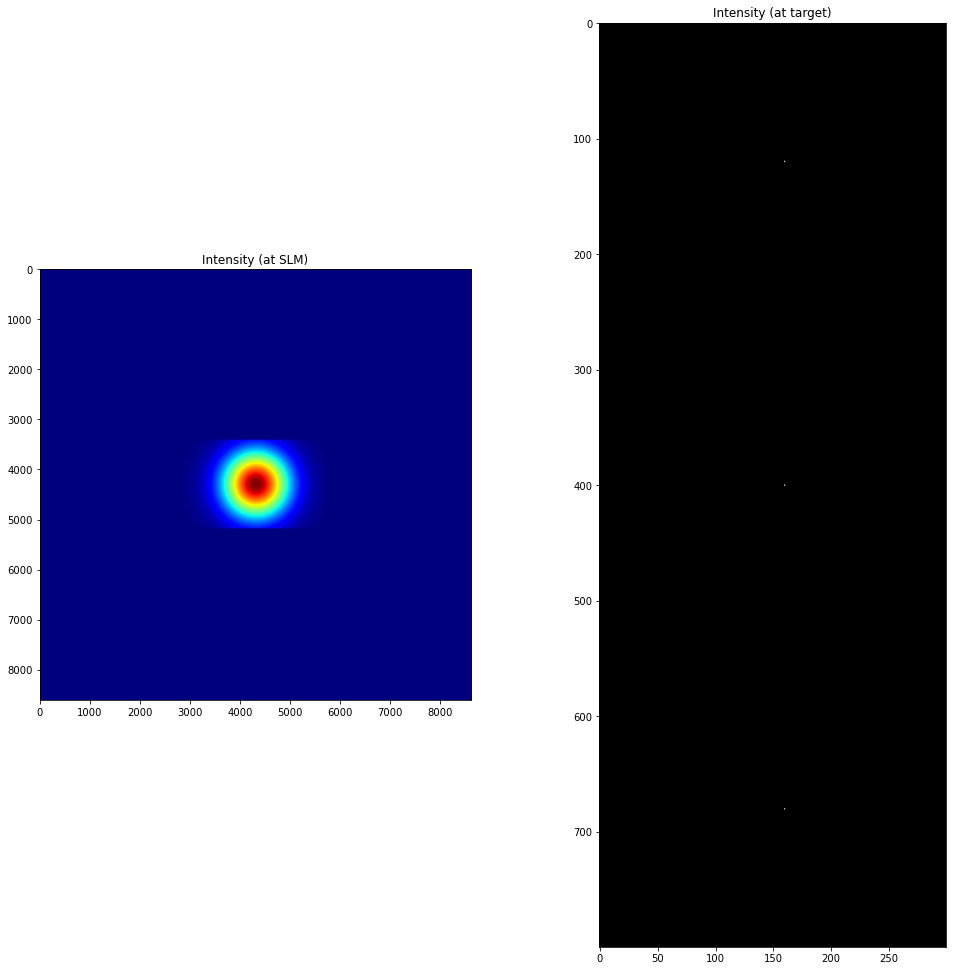

Took 4136.68 sec
<class 'numpy.ndarray'> (8610, 8610) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


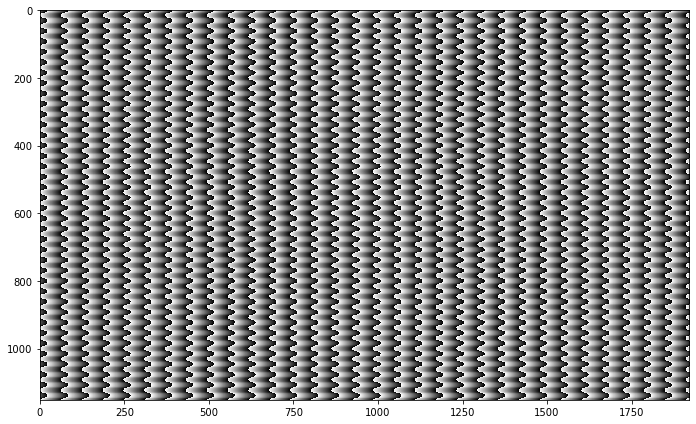

In [12]:
generate_masks(631*nm, Niter = 100, tag = 'MID')

Pixels in the grid: 8610
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (8610, 8610)
<class 'numpy.ndarray'> (8610, 8610) 0.0 255.0 float64


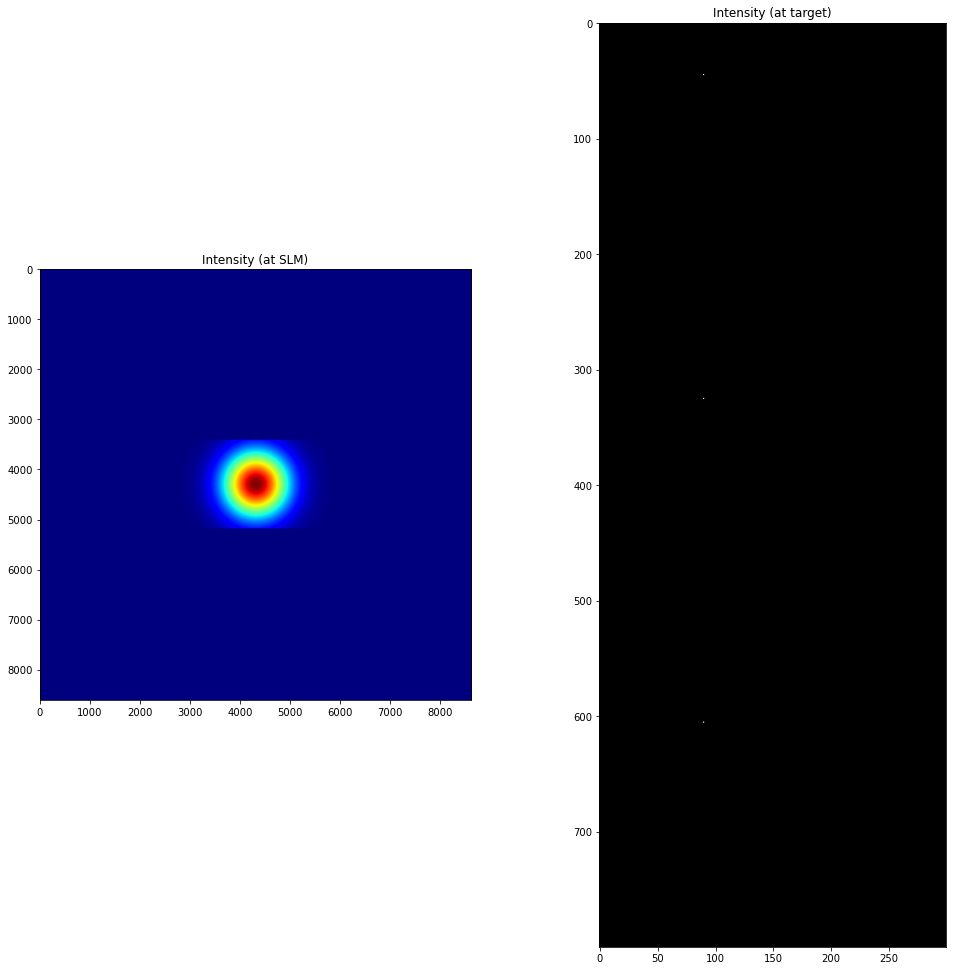

Took 4100.36 sec
<class 'numpy.ndarray'> (8610, 8610) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


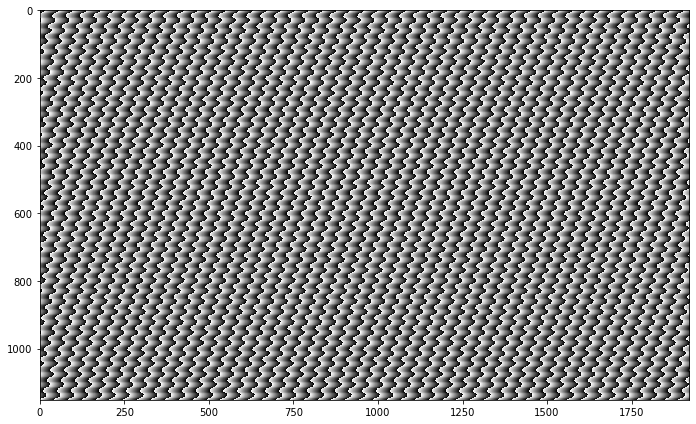

In [13]:
generate_masks(631*nm, Niter = 100, tag = 'FAR')

Pixels in the grid: 8610
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (8610, 8610)
<class 'numpy.ndarray'> (8610, 8610) 0.0 255.0 float64


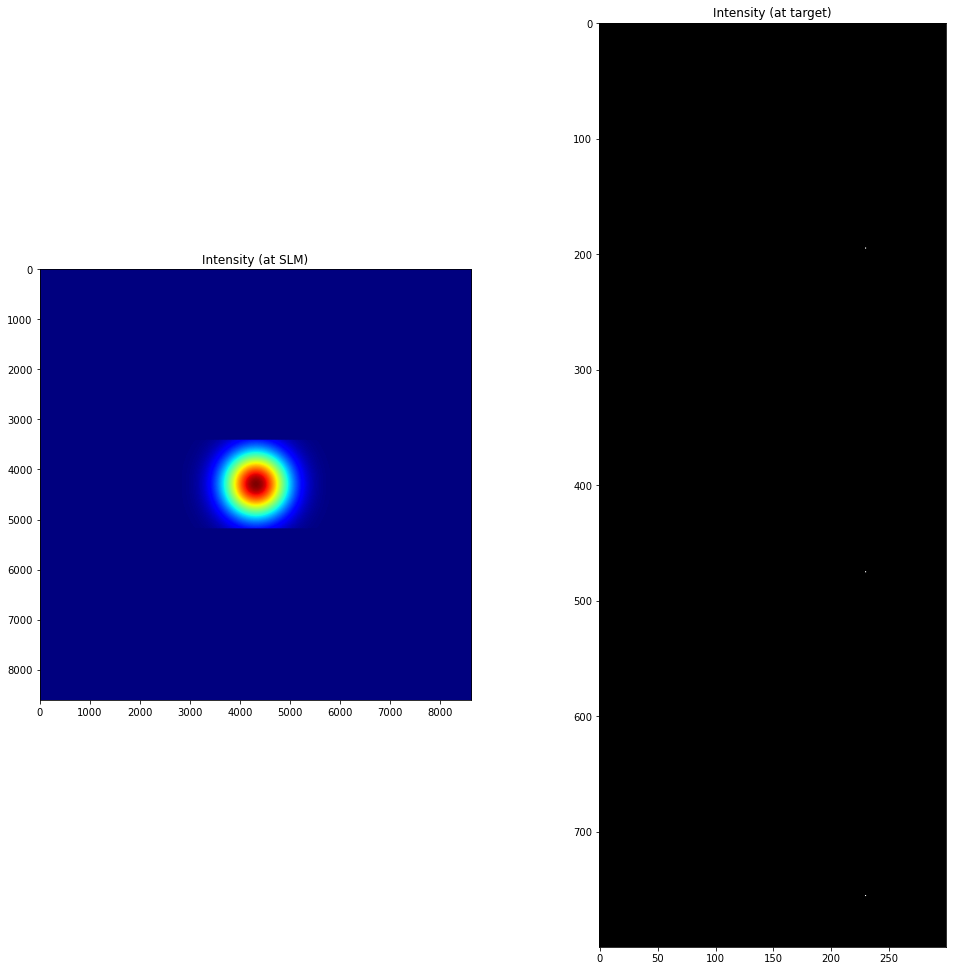

Took 4169.4 sec
<class 'numpy.ndarray'> (8610, 8610) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


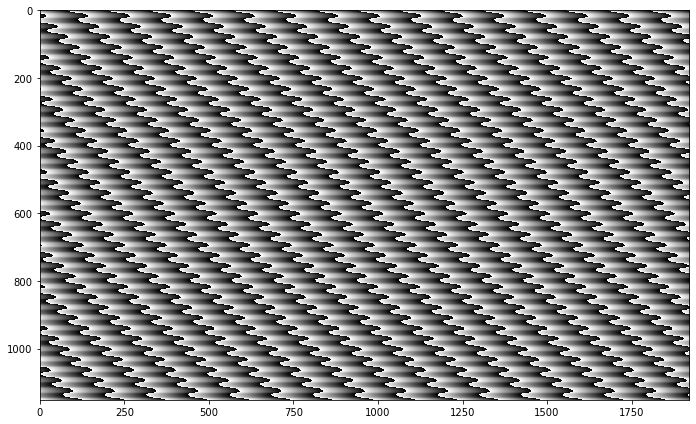

In [14]:
generate_masks(631*nm, Niter = 100, tag = 'NEAR')

Pixels in the grid: 7280
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (7280, 7280)
<class 'numpy.ndarray'> (7280, 7280) 0.0 255.0 float64


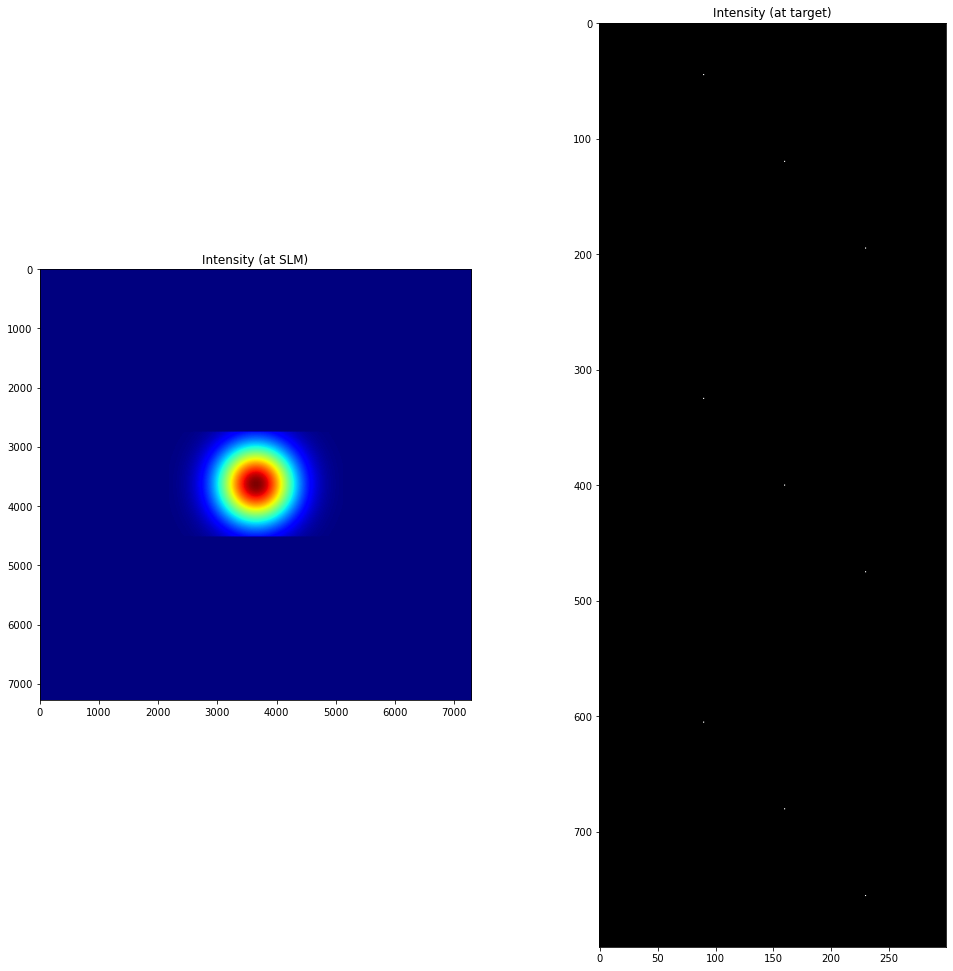

Took 2720.84 sec
<class 'numpy.ndarray'> (7280, 7280) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


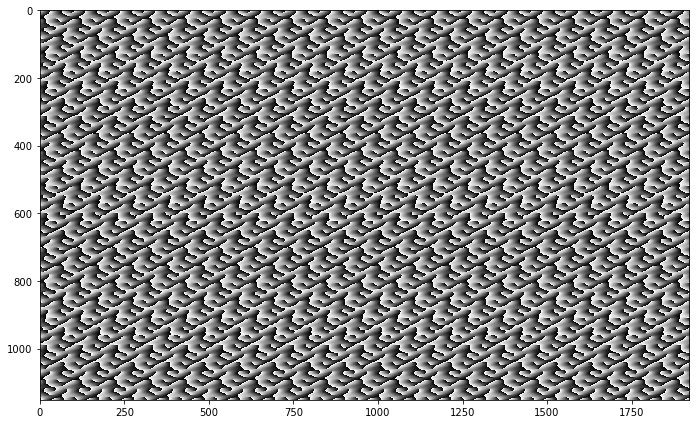

In [15]:
generate_masks(532*nm, Niter = 100, tag = 'MATRIX')

Pixels in the grid: 7280
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (7280, 7280)
<class 'numpy.ndarray'> (7280, 7280) 0.0 255.0 float64


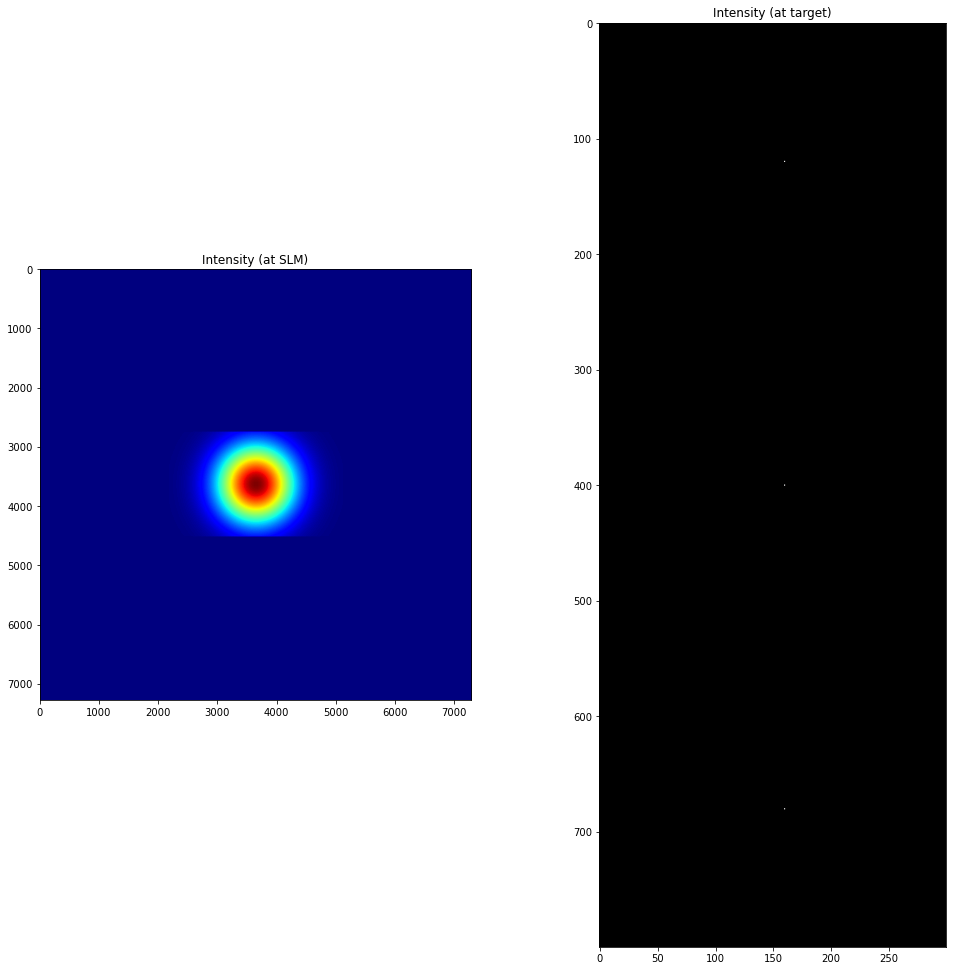

Took 2731.69 sec
<class 'numpy.ndarray'> (7280, 7280) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


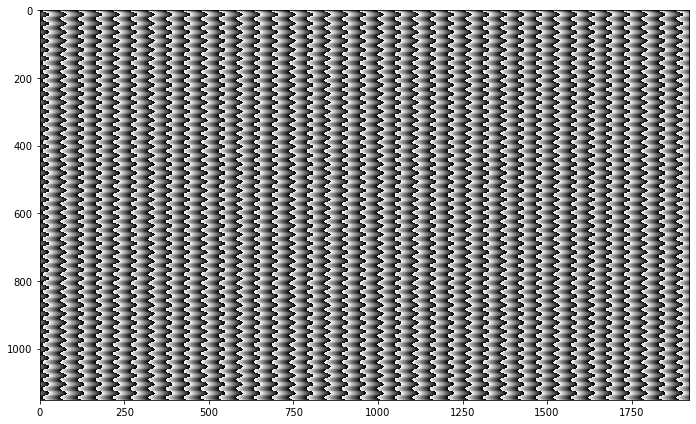

In [16]:
generate_masks(532*nm, Niter = 100, tag = 'MID')

Pixels in the grid: 7280
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (7280, 7280)
<class 'numpy.ndarray'> (7280, 7280) 0.0 255.0 float64


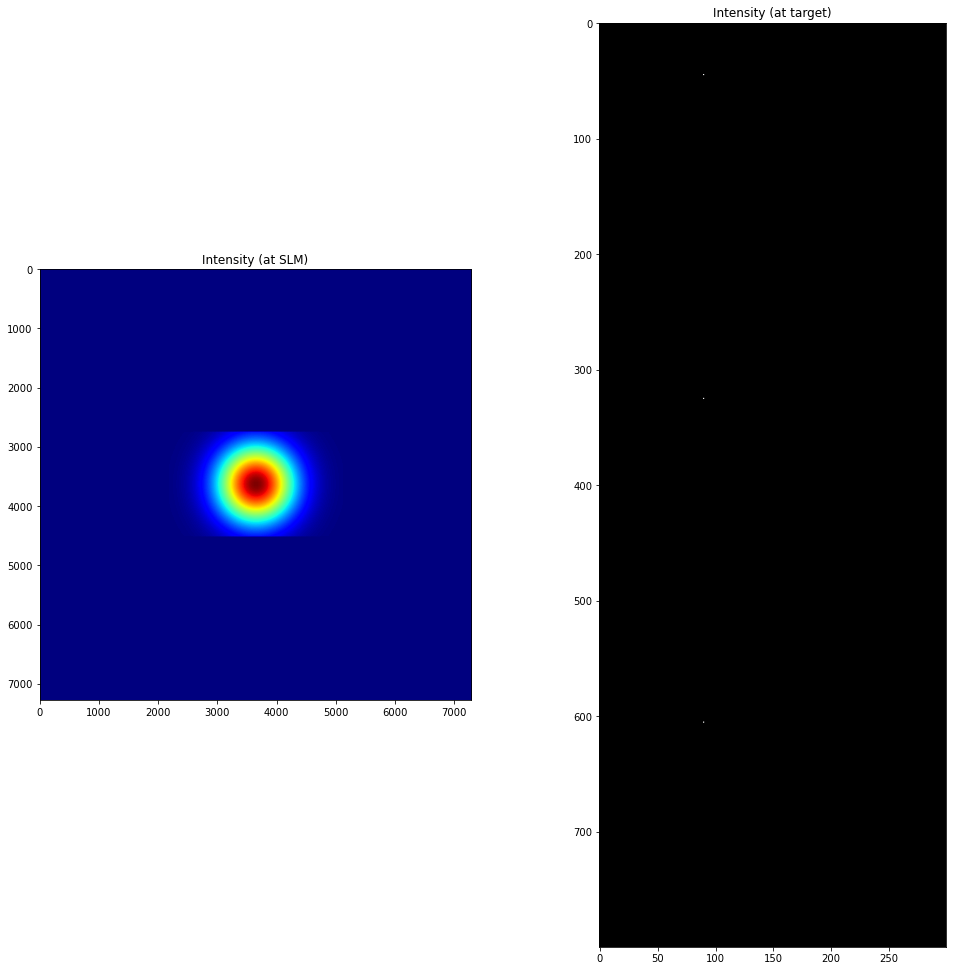

Took 2741.03 sec
<class 'numpy.ndarray'> (7280, 7280) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


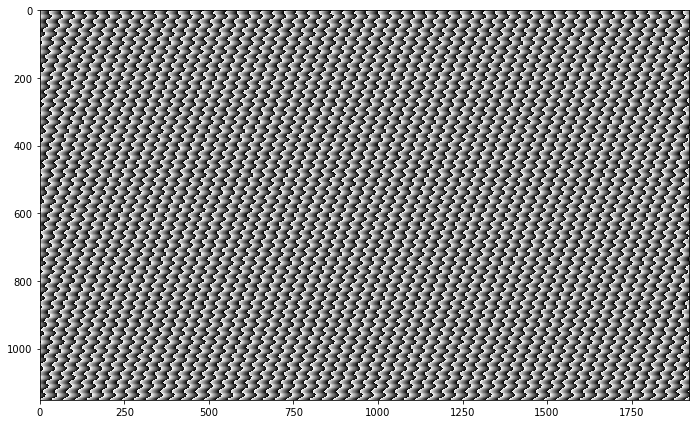

In [17]:
generate_masks(532*nm, Niter = 100, tag = 'FAR')

Pixels in the grid: 7280
Pixels along SLM height: 1920
SLM oversampled. OK to proceed
<class 'numpy.ndarray'> complex128 (7280, 7280)
<class 'numpy.ndarray'> (7280, 7280) 0.0 255.0 float64


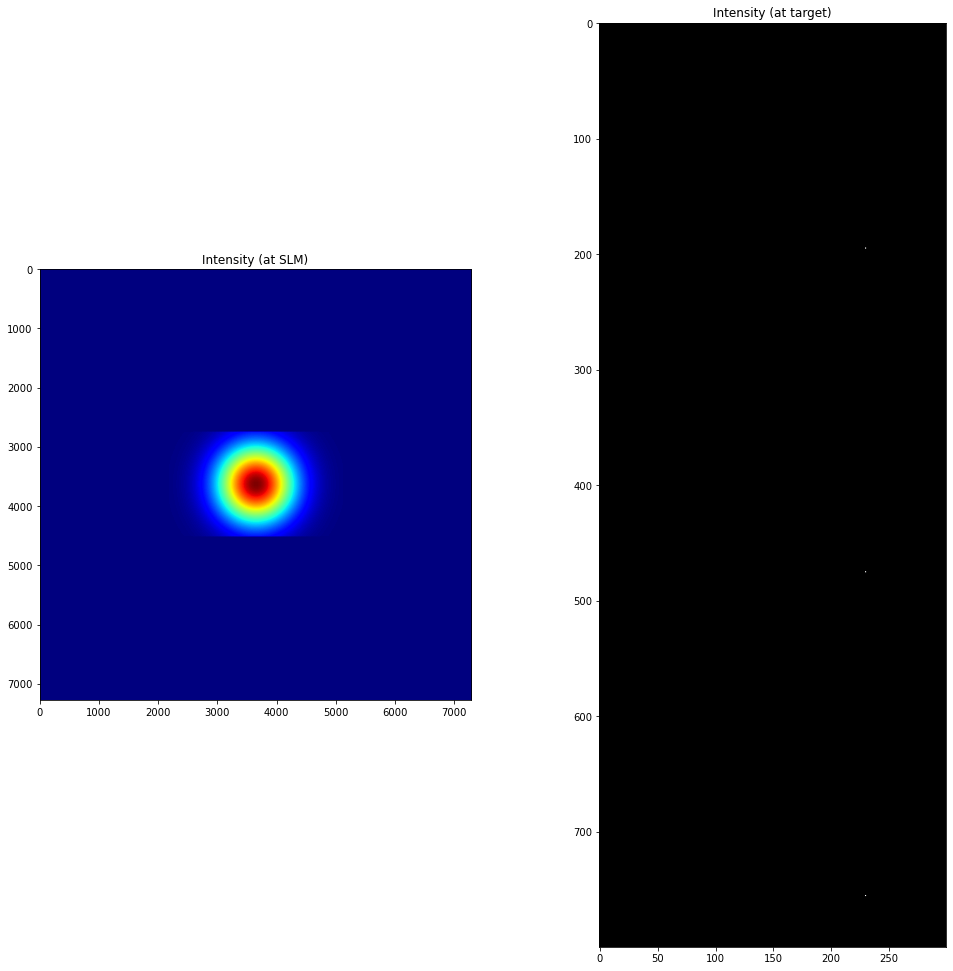

Took 2740.23 sec
<class 'numpy.ndarray'> (7280, 7280) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


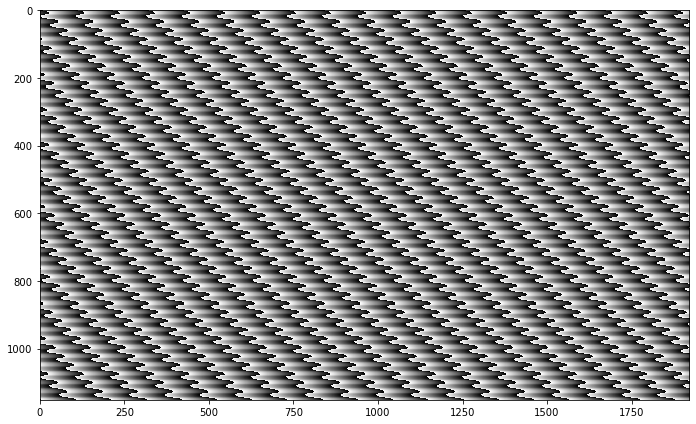

In [18]:
generate_masks(532*nm, Niter = 100, tag = 'NEAR')